<a href="https://colab.research.google.com/github/awesome-astra/docs/blob/main/docs/pages/tools/notebooks/Retrieval_Augmented_Generation_(for_AI_Chatbots).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Llama Index, NBA Knowledge-base Vector Store

Create a Vector Store with Llama index and CassIO, with NBA data to use as a search engine and text generator, backed by Astra DB. Demonstrate multiple Llama index modules and question answering using the framework, including a Gradio Web Interface.

New as of 10/12/23:
 - Added additional team(s) to the result set
 - Add observability
    - Specifically added Weights & Biases Prompts - a suite of LLMOps tools built for the development of LLM-powered applications.

Note: much of dataset build code is credited to lifeofbaka (https://github.com/lifeofbaka)

## Colab-specific setup

#Have an Astra Vector Database available and get ready to upload the Secure Connect Bundle and supply the Token string
(see [Pre-requisites](https://cassio.org/start_here/#vector-database) on cassio.org for details. Remember you need a custom Token with role [Database Administrator](https://awesome-astra.github.io/docs/pages/astra/create-token/)).

Likewise, ensure you have the necessary secret for the LLM provider of your choice: you'll be asked to input it shortly
(see [Pre-requisites](https://cassio.org/start_here/#llm-access) on cassio.org for details).

_Note: this notebook is part of the CassIO documentation. Visit [this page on cassIO.org](https://cassio.org/frameworks/llamaindex/vector-quickstart/)._


In [ ]:
# install required dependencies
! pip install -q --progress-bar off \
    "cassio>=0.1.0" \
    "google-cloud-aiplatform>=1.25.0" \
    "jupyter>=1.0.0" \
    "llama-index" \
    "wandb" \
    "nltk==3.8.1" \
    "pypdf==3.15.2" \
    "python-dotenv==1.0.0" \
    "openai" \
    "langchain" \
    "pypdf" \
    "PyCryptodome" \
    "gradio" \
    "wikipedia" \
    "bs4" \
    "transformers"
exit()

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


⚠️ **Do not mind a "Your session crashed..." message you may see.**

It was us, making sure your kernel restarts with all the correct dependency versions. _You can now proceed with the notebook._

In [ ]:
# imports
from bs4 import BeautifulSoup
import numpy as np
import requests
import re
import pandas as pd
import io
import csv
import wikipedia
from typing import Any, List
import json
import os
import re
from urllib.request import urlopen
import openai
from pathlib import Path
from llama_index import download_loader
from llama_index import (
    GPTVectorStoreIndex,
    GPTSimpleKeywordTableIndex,
    SimpleDirectoryReader,
    LLMPredictor,
    ServiceContext
)
from llama_index import StorageContext, ServiceContext, GPTVectorStoreIndex, LLMPredictor, PromptHelper, SimpleDirectoryReader, load_index_from_storage
from langchain.llms.openai import OpenAIChat
from langchain.chat_models import ChatOpenAI

In [ ]:
# Input your database keyspace name:
ASTRA_DB_KEYSPACE = input('Your Astra DB Keyspace name ')

Your Astra DB Keyspace name vector_preview


In [ ]:
# Input your Astra DB token string, the one starting with "AstraCS:..."
from getpass import getpass
ASTRA_DB_APPLICATION_TOKEN = getpass('Your Astra DB Token ("AstraCS:..."): ')

Your Astra DB Token ("AstraCS:..."): ··········


### Astra DB Secure Connect Bundle

Please upload the Secure Connect Bundle zipfile to connect to your Astra DB instance.

The Secure Connect Bundle is needed to establish a secure connection to the database.
Click [here](https://awesome-astra.github.io/docs/pages/astra/download-scb/#c-procedure) for instructions on how to download it from Astra DB.

In [ ]:
# Upload your Secure Connect Bundle zipfile:
import os
from google.colab import files


print('Please upload your Secure Connect Bundle')
uploaded = files.upload()
if uploaded:
    astraBundleFileTitle = list(uploaded.keys())[0]
    ASTRA_DB_SECURE_BUNDLE_PATH = os.path.join(os.getcwd(), astraBundleFileTitle)
else:
    raise ValueError(
        'Cannot proceed without Secure Connect Bundle. Please re-run the cell.'
    )

Please upload your Secure Connect Bundle


Saving secure-connect-vectordemo.zip to secure-connect-vectordemo.zip


In [ ]:
# colab-specific override of helper functions
from cassandra.cluster import (
    Cluster,
)
from cassandra.auth import PlainTextAuthProvider


def getCQLSession(mode='astra_db'):
    if mode == 'astra_db':
        cluster = Cluster(
            cloud={
                "secure_connect_bundle": ASTRA_DB_SECURE_BUNDLE_PATH,
            },
            auth_provider=PlainTextAuthProvider(
                "token",
                ASTRA_DB_APPLICATION_TOKEN,
            ),
        )
        astraSession = cluster.connect()
        return astraSession
    else:
        raise ValueError('Unsupported CQL Session mode')

def getCQLKeyspace(mode='astra_db'):
    if mode == 'astra_db':
        return ASTRA_DB_KEYSPACE
    else:
        raise ValueError('Unsupported CQL Session mode')

### LLM Provider

In the cell below you can choose between **GCP Vertex AI** or **OpenAI** for your LLM services.
(See [Pre-requisites](https://cassio.org/start_here/#llm-access) on cassio.org for more details).

Make sure you set the `llmProvider` variable and supply the corresponding access secrets in the following cell.

In [ ]:
# Set your secret(s) for LLM access:
llmProvider = 'OpenAI'  # 'GCP_VertexAI', 'Azure_OpenAI'


In [ ]:
from getpass import getpass
if llmProvider == 'OpenAI':
    apiSecret = getpass(f'Your secret for LLM provider "{llmProvider}": ')
    os.environ['OPENAI_API_KEY'] = apiSecret
elif llmProvider == 'GCP_VertexAI':
    # we need a json file
    print(f'Please upload your Service Account JSON for the LLM provider "{llmProvider}":')
    from google.colab import files
    uploaded = files.upload()
    if uploaded:
        vertexAIJsonFileTitle = list(uploaded.keys())[0]
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.join(os.getcwd(), vertexAIJsonFileTitle)
    else:
        raise ValueError(
            'No file uploaded. Please re-run the cell.'
        )
elif llmProvider == 'Azure_OpenAI':
    # a few parameters must be input
    apiSecret = input(f'Your API Key for LLM provider "{llmProvider}": ')
    os.environ['AZURE_OPENAI_API_KEY'] = apiSecret
    apiBase = input('The "Base URL" for your models (e.g. "https://YOUR-RESOURCE-NAME.openai.azure.com"): ')
    os.environ['AZURE_OPENAI_API_BASE'] = apiBase
    apiLLMDepl = input('The name of your LLM Deployment: ')
    os.environ['AZURE_OPENAI_LLM_DEPLOYMENT'] = apiLLMDepl
    apiLLMModel = input('The name of your LLM Model (e.g. "gpt-4"): ')
    os.environ['AZURE_OPENAI_LLM_MODEL'] = apiLLMModel
    apiEmbDepl = input('The name for your Embeddings Deployment: ')
    os.environ['AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT'] = apiEmbDepl
    apiEmbModel = input('The name of your Embedding Model (e.g. "text-embedding-ada-002"): ')
    os.environ['AZURE_OPENAI_EMBEDDINGS_MODEL'] = apiEmbModel

    # The following is probably not going to change for some time...
    os.environ['AZURE_OPENAI_API_VERSION'] = '2023-03-15-preview'
else:
    raise ValueError('Unknown/unsupported LLM Provider')

Your secret for LLM provider "OpenAI": ··········


### Wikipedia Dataset
using help from lifeofbacka to retrieve a dataset from wikipedia. We will focus on NBA teams as the topic of interest. And for demo purposes we'll focus on two teams.

In [ ]:
#wiki links
wiki_txt_links = ['https://raw.githubusercontent.com/lifeofbaka/Datasets/main/Wikipedia/wiki' + str(i)+ '.txt' for i in range(1,9)] #if wiki size changes update the range.

In [ ]:
# topics

# basketball_teams = [
#     "Atlanta Hawks",
#     "Boston Celtics",
#     "Brooklyn Nets",
#     "Charlotte Hornets",
#     "Chicago Bulls",
#     "Cleveland Cavaliers",
#     "Dallas Mavericks",
#     "Denver Nuggets",
#     "Detroit Pistons",
#     "Golden State Warriors",
#     "Houston Rockets",
#     "Indiana Pacers",
#     "Los Angeles Clippers",
#     "Los Angeles Lakers",
#     "Memphis Grizzlies",
#     "Miami Heat",
#     "Milwaukee Bucks",
#     "Minnesota Timberwolves",
#     "New Orleans Pelicans",
#     "New York Knicks",
#     "Oklahoma City Thunder",
#     "Orlando Magic",
#     "Philadelphia 76ers",
#     "Phoenix Suns",
#     "Portland Trail Blazers",
#     "Sacramento Kings",
#     "San Antonio Spurs",
#     "Toronto Raptors",
#     "Utah Jazz",
#     "Washington Wizards"
# ]
'''

In [ ]:
# smaller test case with two teams
basketball_teams = [ "Utah Jazz","Dallas Mavericks"]

In [ ]:
len(basketball_teams)

2

In [ ]:
# Wiki Extraction
# find every wiki that has one of the values in the topic case. Then add values to a list to be read later

nba_wiki = []
for i in range(len(wiki_txt_links)):
   data = urlopen(wiki_txt_links[i]) # it's a file like object and works just like a file
   articles = [line.strip() for line in data] # files are iterable
   for team in basketball_teams:
      for topic in articles:
        if team in str(topic):
          pattern = r'\xe2\x80\x93'
          matches = re.findall(pattern, str(topic))
          if not matches:
            nba_wiki.append(str(topic)[2:-1])
print (len(nba_wiki))

360


In [ ]:
nba_wiki

['1978-79 Utah Jazz season',
 '1978\\xe2\\x80\\x9379 Utah Jazz season',
 '1979-80 Utah Jazz',
 '1979-80 Utah Jazz season',
 '1979\\xe2\\x80\\x9380 Utah Jazz',
 '1979\\xe2\\x80\\x9380 Utah Jazz season',
 '1980-81 Utah Jazz',
 '1980-81 Utah Jazz season',
 '1980\\xe2\\x80\\x9381 Utah Jazz',
 '1980\\xe2\\x80\\x9381 Utah Jazz season',
 '1981-82 Utah Jazz',
 '1981-82 Utah Jazz season',
 '1981\\xe2\\x80\\x9382 Utah Jazz',
 '1981\\xe2\\x80\\x9382 Utah Jazz season',
 '1982-83 Utah Jazz',
 '1982-83 Utah Jazz season',
 '1982\\xe2\\x80\\x9383 Utah Jazz',
 '1982\\xe2\\x80\\x9383 Utah Jazz season',
 '1983-84 Utah Jazz',
 '1983-84 Utah Jazz season',
 '1983\\xe2\\x80\\x9384 Utah Jazz',
 '1983\\xe2\\x80\\x9384 Utah Jazz season',
 '1984-85 Utah Jazz',
 '1984-85 Utah Jazz season',
 '1984\\xe2\\x80\\x9385 Utah Jazz',
 '1984\\xe2\\x80\\x9385 Utah Jazz season',
 '1985-86 Utah Jazz',
 '1985-86 Utah Jazz season',
 '1985\\xe2\\x80\\x9386 Utah Jazz',
 '1985\\xe2\\x80\\x9386 Utah Jazz season',
 '1986-87 Utah Jaz

In [ ]:
nba_wiki_ = set()
for i in range(len(nba_wiki)):
  try:
    if nba_wiki[i] in nba_wiki[i+1]:
      nba_wiki_.add(nba_wiki[i+1])
    else:
      nba_wiki_.add(nba_wiki(i))
  except:
    nba_wiki_.add(nba_wiki[i])
nba_wiki_ = list(nba_wiki_)
print (len(nba_wiki_))

189


In [ ]:
sorted(nba_wiki_)

['1978-79 Utah Jazz season',
 '1978\\xe2\\x80\\x9379 Utah Jazz season',
 '1979-80 Utah Jazz season',
 '1979\\xe2\\x80\\x9380 Utah Jazz season',
 '1980-81 Dallas Mavericks season',
 '1980-81 Utah Jazz season',
 '1980\\xe2\\x80\\x9381 Dallas Mavericks season',
 '1980\\xe2\\x80\\x9381 Utah Jazz season',
 '1981-82 Dallas Mavericks season',
 '1981-82 Utah Jazz season',
 '1981\\xe2\\x80\\x9382 Dallas Mavericks season',
 '1981\\xe2\\x80\\x9382 Utah Jazz season',
 '1982-83 Dallas Mavericks season',
 '1982-83 Utah Jazz season',
 '1982\\xe2\\x80\\x9383 Dallas Mavericks season',
 '1982\\xe2\\x80\\x9383 Utah Jazz season',
 '1983-84 Dallas Mavericks season',
 '1983-84 Utah Jazz season',
 '1983\\xe2\\x80\\x9384 Dallas Mavericks season',
 '1983\\xe2\\x80\\x9384 Utah Jazz season',
 '1984-85 Dallas Mavericks season',
 '1984-85 Utah Jazz season',
 '1984\\xe2\\x80\\x9385 Dallas Mavericks season',
 '1984\\xe2\\x80\\x9385 Utah Jazz season',
 '1985-86 Dallas Mavericks season',
 '1985-86 Utah Jazz season',
 

In [ ]:
# remove duplicates
to_remove = ['(football)','(NHL)', '(AFL)', '(hockey)', '(AFL, 1926)', '(American football)', '(WFL)', '(UHL)']
for line in nba_wiki_:
  for item in to_remove:
    if item in line:
      print (line)
      nba_wiki_.remove(line)
print (len(nba_wiki_))


189


In [ ]:
#load data function. The function is reliant on a number of table finder functions that have also been assigned below as draft picks and roster.
# The functions find specific table values within the pagent context using Beautiful Soup then output a dictionary from a working dataframe which is then stored within the results dictionary and usable sub topic storage for JSON.

#test
#articles = ['1968–69 Atlanta Hawks season','1968–69_Chicago_Bulls_season']


#WIKIPEDIA PULL
def load_data( pages: List[str], lang: str = "en", **load_kwargs: Any):
    results = []
    for page in pages:
        wikipedia.set_lang(lang)
        try:
          page_content = wikipedia.page(page, **load_kwargs).content
          summary = page_content
          matches = re.findall(r'==\s(.*?)\s==', summary)

          if 'Draft picks' in matches:
              draftpick = draft_picks(page)
          else:
              draftpick = ''
          if 'Roster' in matches:
              team_roster = roster(page)
              pull.append(page)
          else:
              team_roster = ['','']

          data = {page: {"summary": summary, "Draft Pick": draftpick, "Coach": team_roster[0], "Roster": team_roster[1]}}
          results.append(data)
        except:
          pass

    return results

#Tables = re.findall(r"\n== (.*?) ==\n", summary[0])
#print (Tables)


#################################################################################################


def draft_picks(article):
    url = requests.get(f'https://en.wikipedia.org/wiki/{article}').content
    soup = BeautifulSoup(url, 'html.parser')
    tables = []
    for i in soup.find_all('table'):
        tables.append(i)
    for i in range(len(tables)):
        try:
          table_text = tables[i].text
          table_text = table_text.split('\n')

          # find table columns
          col_finder = ' '.join(table_text)
          cols = col_finder.split('   ')
          cols = cols[0].split(' ')

          result_cols = []
          for item in cols:
              if item != '':
                  result_cols.append(item)


          #find table data
          result = []
          pattern = r"(?<=\xa0)\w++"
          for record in table_text:
              match = re.search(r"\xa0(.*)", record)
              if match:
                  result.append(match.group(1))
              else:
                  if record != '':
                      result.append(record)
          result = result[len(result_cols):]
          result = np.array(result)
          shaper = (len(result_cols),int(result.shape[0]/len(result_cols)))

          result = result.reshape(shaper[1],shaper[0])

          df = pd.DataFrame(result, columns=result_cols)
          dictionary = df.to_dict()
          return dictionary
        except:
            pass
    return "could not find table"


def roster(article):
    url = requests.get(f'https://en.wikipedia.org/wiki/{article}').content
    soup = BeautifulSoup(url, 'html.parser')
    tables = []
    for i in soup.find_all('table'):
        tables.append(i)

    for i in range(len(tables)):
        try:
            table_text = tables[i].text
            table_text = table_text.split('\n')

            # find table columns
            col_finder = ' '.join(table_text)
            cols = col_finder.split('   ')
            cols = ' '.join(cols[1:4]).split(' ')

            result_cols = []
            for i in cols:
                if i != '':
                    result_cols.append(i)
            result_cols = result_cols[2:7] + [' '.join(result_cols[7:9])] + result_cols[-1:]


            #find table data
            result = []
            for record in table_text:
                matches = re.findall(r'\xa0', record)
                if matches:
                    result.append(record.replace('\xa0',' '))
                else:
                    if record != '':
                        result.append(record)
            result = result[result.index('From') + 1:result.index('Head coach')]


            #Head Coach


            try:

                shaper = (len(result_cols), int(len(result) / len(result_cols)))
                n_result = np.array(result)
                result = n_result.reshape(shaper[1], shaper[0])

                df = pd.DataFrame(result, columns=result_cols)
                roster_dictionary = df.to_dict()
                coach = {table_text[table_text.index('Head coach'): table_text.index('Head coach') + 1][0]:
                             table_text[table_text.index('Head coach') + 1: table_text.index('Head coach') + 2][0]}

                return coach, roster_dictionary
            except:
                result_cols.remove('DOB (YYYY-MM-DD)')
                result = np.array(result)
                shaper = (len(result_cols), int(result.shape[0] / len(result_cols)))
                result = result.reshape(shaper[1], shaper[0])

                df = pd.DataFrame(result, columns=result_cols)
                new_column = [None for i in range(len(df))]
                position = df.columns.get_loc('Weight') + 1
                df.insert(position, 'DOB (YYYY-MM-DD)', new_column)
                roster_dictionary = df.to_dict()
                coach = {table_text[table_text.index('Head coach'): table_text.index('Head coach') + 1][0]:
                             table_text[table_text.index('Head coach') + 2: table_text.index('Head coach') + 3][0]}

                return coach, roster_dictionary
        except:
            pass
    return "could not find table"

In [ ]:
test_i = nba_wiki_.index("2010-11 Dallas Mavericks season")
test_i

163

In [ ]:
nba_wiki_[121]

'2000-01 Utah Jazz season'

In [ ]:
draft_picks([nba_wiki_[121]])

'could not find table'

### JSON

Call the load function for every value previously extraced and write a JSON file

In [ ]:
len(nba_wiki_)

189

In [ ]:
pull = []
for value in load_data(pages=sorted(nba_wiki_)):
    for key in value:
      file_name = key.replace("-"," ")
      file_name = file_name.replace(" ","_")
      pull.append(file_name)
      with open(f"{file_name}.json", "w") as file:
        json.dump(value, file, indent=4)

<ipython-input-16-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-16-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-16-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-16-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-16-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-16-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-16-4a317707f5e6>:81: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-inpu

In [ ]:
#files in content
sorted(pull)

['1978_79_Utah_Jazz_season',
 '1979-80 Utah Jazz season',
 '1979_80_Utah_Jazz_season',
 '1980-81 Dallas Mavericks season',
 '1980-81 Utah Jazz season',
 '1980_81_Dallas_Mavericks_season',
 '1980_81_Utah_Jazz_season',
 '1981-82 Dallas Mavericks season',
 '1981-82 Utah Jazz season',
 '1981_82_Dallas_Mavericks_season',
 '1981_82_Utah_Jazz_season',
 '1982-83 Dallas Mavericks season',
 '1982-83 Utah Jazz season',
 '1982_83_Dallas_Mavericks_season',
 '1982_83_Utah_Jazz_season',
 '1983-84 Dallas Mavericks season',
 '1983-84 Utah Jazz season',
 '1983_84_Dallas_Mavericks_season',
 '1983_84_Utah_Jazz_season',
 '1984-85 Dallas Mavericks season',
 '1984-85 Utah Jazz season',
 '1984_85_Dallas_Mavericks_season',
 '1984_85_Utah_Jazz_season',
 '1985-86 Dallas Mavericks season',
 '1985-86 Utah Jazz season',
 '1985_86_Dallas_Mavericks_season',
 '1985_86_Utah_Jazz_season',
 '1986-87 Dallas Mavericks season',
 '1986-87 Utah Jazz season',
 '1986_87_Dallas_Mavericks_season',
 '1986_87_Utah_Jazz_season',
 '1

In [ ]:
print (len(pull))
print(len(nba_wiki_))

188
189


### Load JSON files into Llama Index

single document test case

In [ ]:
print (os.listdir())
print (len(os.listdir()))

['.config', '2022_23_Utah_Jazz_season.json', '2015_16_Dallas_Mavericks_season.json', '2020_21_Utah_Jazz_season.json', '1985_86_Utah_Jazz_season.json', '1982_83_Utah_Jazz_season.json', '2008_09_Dallas_Mavericks_season.json', '2019_20_Dallas_Mavericks_season.json', 'Dallas_Mavericks_head_coaches.json', '1991_92_Utah_Jazz_season.json', '1993_94_Dallas_Mavericks_season.json', '2009_10_Utah_Jazz_season.json', '2011_12_Utah_Jazz_season.json', '1989_90_Dallas_Mavericks_season.json', '2016_17_Utah_Jazz_season.json', '1978_79_Utah_Jazz_season.json', '1997_98_Utah_Jazz_season.json', '2009_10_Dallas_Mavericks_season.json', '1989_90_Utah_Jazz_season.json', '1999_2000_Dallas_Mavericks_season.json', '2021_22_Dallas_Mavericks_season.json', '1988_89_Dallas_Mavericks_season.json', '2001_02_Dallas_Mavericks_season.json', '1983_84_Utah_Jazz_season.json', '2007_08_Dallas_Mavericks_season.json', '1997_98_Dallas_Mavericks_season.json', '2008_09_Utah_Jazz_season.json', '2005_06_Dallas_Mavericks_season.json',

In [ ]:
p =os.listdir()[1:-1]

In [ ]:
file_path = "/content/"

In [ ]:
pull_ = set(i for i in pull)
pull

['1979-80 Utah Jazz season',
 '1980-81 Dallas Mavericks season',
 '1980-81 Utah Jazz season',
 '1981-82 Dallas Mavericks season',
 '1981-82 Utah Jazz season',
 '1982-83 Dallas Mavericks season',
 '1982-83 Utah Jazz season',
 '1983-84 Dallas Mavericks season',
 '1983-84 Utah Jazz season',
 '1984-85 Dallas Mavericks season',
 '1984-85 Utah Jazz season',
 '1985-86 Dallas Mavericks season',
 '1985-86 Utah Jazz season',
 '1986-87 Dallas Mavericks season',
 '1986-87 Utah Jazz season',
 '1987-88 Dallas Mavericks season',
 '1987-88 Utah Jazz season',
 '1988-89 Dallas Mavericks season',
 '1988-89 Utah Jazz season',
 '1989-90 Dallas Mavericks season',
 '1989-90 Utah Jazz season',
 '1990-91 Dallas Mavericks season',
 '1990-91 Utah Jazz season',
 '1991-92 Dallas Mavericks season',
 '1991-92 Utah Jazz season',
 '1992-93 Dallas Mavericks season',
 '1992-93 Utah Jazz season',
 '1993-94 Dallas Mavericks season',
 '1993-94 Utah Jazz season',
 '1994-95 Dallas Mavericks season',
 '1994-95 Utah Jazz seaso

In [ ]:
paths = []
for i in pull:
  i = i.replace("-", " ")
  i = i.replace(" ",("_"))
  paths.append(file_path +i+".json")

In [ ]:
print(paths[0:2])

['/content/1979_80_Utah_Jazz_season.json', '/content/1980_81_Dallas_Mavericks_season.json']


In [ ]:
from pathlib import Path
from llama_index import download_loader

JSONReader = download_loader("JSONReader")

loader = JSONReader()


In [ ]:
paths[0]

'/content/1979_80_Utah_Jazz_season.json'

In [ ]:
document = loader.load_data(Path(paths[34]))

In [ ]:
#example of what the fully working JSON file should look like
document

[Document(id_='51f9906f-8948-4348-ae3e-f6af8fdcca19', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, hash='92f369d7c0a6ebeac8efc22ce8dabe8073b2cded9f72b048177d2ad90233d70e', text='"1996-97 Utah Jazz season"', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n')]

In [ ]:
print('Document ID:', document[0].doc_id, 'Document Hash:', document[0].hash)

Document ID: 51f9906f-8948-4348-ae3e-f6af8fdcca19 Document Hash: 92f369d7c0a6ebeac8efc22ce8dabe8073b2cded9f72b048177d2ad90233d70e


### Colab preamble completed

## The following cells constitute the demo notebook proper.

# LlamaIndex, Vector Store

Create a Vector Store with LamaIndex and CassIO, and build a powerful search engine and text generator, backed by Astra DB / Apache Cassandra®.

### Table of contents:

- Setup (database, LLM+embeddings)
- Create Astra vector store
- Insert documents in it
- Test answering questions using a single doc with AStra Vector Search, CassIO and LlamaIndex
- Use Gradio web interface to showcase Q&A across multiple docs
- Cleanup (optional)

_**NOTE:** this uses Cassandra's "Vector Similarity Search" capability.
Make sure you are connecting to a vector-enabled database for this demo._

## Setup

In [ ]:
from llama_index import VectorStoreIndex, SimpleDirectoryReader, StorageContext

# for observability
from llama_index.callbacks import CallbackManager, CBEventType
from llama_index.callbacks import LlamaDebugHandler, WandbCallbackHandler
from llama_index import (
    SummaryIndex,
    GPTTreeIndex,
    GPTVectorStoreIndex,
    ServiceContext,
    SimpleDirectoryReader,
    LLMPredictor,
    GPTSimpleKeywordTableIndex,
    StorageContext,
)
from llama_index.indices.composability import ComposableGraph
from llama_index import load_index_from_storage, load_graph_from_storage
#from llama_index.llms import OpenAI



This is the LlamaIndex class providing support for Astra DB / Cassandra:

In [ ]:
from llama_index.vector_stores import CassandraVectorStore

A database connection is needed to access Cassandra. The following assumes
that a _vector-search-capable Astra DB instance_ is available. Adjust as needed.

In [ ]:
# creation of the DB connection
cqlMode = 'astra_db'
session = getCQLSession(mode=cqlMode)
keyspace = getCQLKeyspace(mode=cqlMode)

ERROR:cassandra.connection:Closing connection <AsyncoreConnection(133764825281776) a4c29bc6-b900-44c5-b980-584a0c4542b5-us-east1.db.astra.datastax.com:29042:f07b10c5-f2b9-48aa-942d-2b906062c418> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


Both an LLM and an embedding function are required.

Below is the logic to instantiate the LLM and embeddings of choice. We chose to leave it in the notebooks for clarity.

In [ ]:
import os
# creation of the LLM resources


if llmProvider == 'OpenAI':
    os.environ['OPENAI_API_TYPE'] = 'open_ai'
    from llama_index.llms import OpenAI
    from llama_index.embeddings import OpenAIEmbedding
    llm = OpenAI(temperature=0)
    myEmbedding = OpenAIEmbedding()
    vector_dimension = 1536
    print("LLM+embeddings from OpenAI")
elif llmProvider == 'GCP_VertexAI':
    from llama_index import LangchainEmbedding
    # LlamaIndex lets you plug any LangChain's LLM+embeddings:
    from langchain.llms import VertexAI
    from langchain.embeddings import VertexAIEmbeddings
    llm = VertexAI()
    lcEmbedding = VertexAIEmbeddings()
    vector_dimension = len(lcEmbedding.embed_query("This is a sample sentence."))
    # ... if you take care of wrapping the LangChain embedding like this:
    myEmbedding = LangchainEmbedding(lcEmbedding)
    print("LLM+embeddings from Vertex AI")
elif llmProvider == 'Azure_OpenAI':
    os.environ['OPENAI_API_TYPE'] = 'azure'
    os.environ['OPENAI_API_VERSION'] = os.environ['AZURE_OPENAI_API_VERSION']
    os.environ['OPENAI_API_BASE'] = os.environ['AZURE_OPENAI_API_BASE']
    os.environ['OPENAI_API_KEY'] = os.environ['AZURE_OPENAI_API_KEY']
    from llama_index import LangchainEmbedding
    # LlamaIndex lets you plug any LangChain's LLM+embeddings:
    from langchain.llms import AzureOpenAI
    from langchain.embeddings import OpenAIEmbeddings
    llm = AzureOpenAI(temperature=0, model_name=os.environ['AZURE_OPENAI_LLM_MODEL'],
                      engine=os.environ['AZURE_OPENAI_LLM_DEPLOYMENT'])
    lcEmbedding = OpenAIEmbeddings(model=os.environ['AZURE_OPENAI_EMBEDDINGS_MODEL'],
                                   deployment=os.environ['AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT'])
    vector_dimension = len(lcEmbedding.embed_query("This is a sample sentence."))
    # ... if you take care of wrapping the LangChain embedding like this:
    myEmbedding = LangchainEmbedding(lcEmbedding)
    print('LLM+embeddings from Azure OpenAI')
else:
    raise ValueError('Unknown LLM provider.')

print(f"Vector dimension for this embedding model: {vector_dimension}")

LLM+embeddings from OpenAI
Vector dimension for this embedding model: 1536


In [ ]:
# Observability
# option 1 (errored with "NameError: name 'llama_index' is not defined")
#from llama_index import set_global_handler
#set_global_handler("wandb", run_args={"project": "llamaindex"})
#wandb_callback = llama_index.global_handler
#service_context = ServiceContext.from_defaults(llm=llm)

# Used option
llama_debug = LlamaDebugHandler(print_trace_on_end=True)
# wandb.init args
run_args = dict(
    project="llamaindex",
    )
wandb_callback = WandbCallbackHandler(run_args=run_args)
#callback_manager = CallbackManager([llama_debug, wandb_callback]) #this errored so went with the straight llama_debug below
callback_manager = CallbackManager([llama_debug])
#service_context = ServiceContext.from_defaults(
#    callback_manager=callback_manager, llm=llm
#    )

# After running the above cell, it provides the W&B run page URL. This contains a trace table with all the events tracked using Weights and Biases’ Prompts feature.
# e.g. https://wandb.ai/kasey-parker/llamaindex/runs/2yf6kpm1?workspace=user-kasey-parker

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The following cell ensures that throughout all of LlamaIndex the LLM and embedding function instantiated above will be used:

In [ ]:
from llama_index import ServiceContext
from llama_index import set_global_service_context

service_context = ServiceContext.from_defaults(
    callback_manager=callback_manager,
    llm=llm,
    embed_model=myEmbedding,
    chunk_size=256,
)
set_global_service_context(service_context)

## Create vector store

In [ ]:
table_name = 'vs_nba_ll_' + llmProvider

In the LlamaIndex abstractions, the `CassandraVectorStore` instance is best wrapped into the creation of a "storage context", which you'll momentarily use to create the index proper:

In [ ]:
storage_context = StorageContext.from_defaults(
    vector_store = CassandraVectorStore(
        session=session,
        keyspace=keyspace,
        table=table_name,
        embedding_dimension=vector_dimension,
        insertion_batch_size=15,
    )
)

## Insert documents into Astra

In [ ]:
titles = pull

In [ ]:
print(titles[0])
print(len(titles))

1979-80 Utah Jazz season
188


In [ ]:
from llama_index.storage.storage_context import StorageContext

openai.api_key = apiSecret

#if index_name not in pinecone.list_indexes():
 # pinecone.create_index(name=index_name, dimension=1536, metric="cosine")
  # pinecone.create_index(index_name, dimension=len(embeds[0]))
# connect to index
# index = pinecone.Index(index_name)
# pinecone.create_index(name=index_name, dimension=1536, metric="cosine")

aa_indices = {}
index_summaries = {}

for astra_title, name in zip(titles, paths):
    metadata_filters = {"name": name}
    storage_context = StorageContext.from_defaults(
      vector_store = CassandraVectorStore(
        session=session,
        keyspace=keyspace,
        table=table_name,
        embedding_dimension=vector_dimension,
        insertion_batch_size=15,
      )
    )

    #aa_docs = SimpleDirectoryReader(input_files=[i for i in paths]).load_data()


    #try:
    document = loader.load_data(Path(name))
    aa_indices[name] = GPTVectorStoreIndex.from_documents(document, storage_context=storage_context)
    aa_indices[name].index_struct.index_id = astra_title
    #except:
    #  pass

    index_summaries[name] = f"Wikipedia article about {name}"

# note the wandb trace messages provided by the added observability

**********
Trace: index_construction
    |_node_parsing ->  0.003564 seconds
      |_chunking ->  0.000377 seconds
    |_embedding ->  0.434178 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000426 seconds
      |_chunking ->  7.6e-05 seconds
    |_embedding ->  0.129373 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000595 seconds
      |_chunking ->  0.000111 seconds
    |_embedding ->  0.140508 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000375 seconds
      |_chunking ->  6.9e-05 seconds
    |_embedding ->  0.130116 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000465 seconds
      |_chunking ->  7e-05 seconds
    |_embedding ->  0.133827 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000437 seconds
      |_chunking ->  6.7e-05 seconds
    |_embedding ->  0.126748 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000442 seconds
      |_chunking ->  8e-05 seconds
    |_embedding ->  0.182791 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00037 seconds
      |_chunking ->  6.6e-05 seconds
    |_embedding ->  0.109642 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000585 seconds
      |_chunking ->  0.000101 seconds
    |_embedding ->  0.118045 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000398 seconds
      |_chunking ->  7.1e-05 seconds
    |_embedding ->  0.131014 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000402 seconds
      |_chunking ->  8e-05 seconds
    |_embedding ->  0.161117 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000383 seconds
      |_chunking ->  7.1e-05 seconds
    |_embedding ->  0.118401 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000454 seconds
      |_chunking ->  7.8e-05 seconds
    |_embedding ->  0.149596 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000447 seconds
      |_chunking ->  0.000116 seconds
    |_embedding ->  0.123001 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000577 seconds
      |_chunking ->  0.000112 seconds
    |_embedding ->  0.131113 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000476 seconds
      |_chunking ->  9.1e-05 seconds
    |_embedding ->  0.131767 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000425 seconds
      |_chunking ->  0.000102 seconds
    |_embedding ->  0.118626 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000618 seconds
      |_chunking ->  0.000213 seconds
    |_embedding ->  0.105034 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000448 seconds
      |_chunking ->  9e-05 seconds
    |_embedding ->  0.190763 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000402 seconds
      |_chunking ->  8.1e-05 seconds
    |_embedding ->  0.13162 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00041 seconds
      |_chunking ->  7.4e-05 seconds
    |_embedding ->  0.1587 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000561 seconds
      |_chunking ->  0.000115 seconds
    |_embedding ->  0.15632 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000439 seconds
      |_chunking ->  9.3e-05 seconds
    |_embedding ->  0.115052 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000443 seconds
      |_chunking ->  7.4e-05 seconds
    |_embedding ->  0.10718 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000465 seconds
      |_chunking ->  0.000118 seconds
    |_embedding ->  0.172419 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000536 seconds
      |_chunking ->  0.000107 seconds
    |_embedding ->  0.120642 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00049 seconds
      |_chunking ->  9.5e-05 seconds
    |_embedding ->  0.120453 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000398 seconds
      |_chunking ->  9.8e-05 seconds
    |_embedding ->  0.137213 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000402 seconds
      |_chunking ->  9.5e-05 seconds
    |_embedding ->  0.171795 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000375 seconds
      |_chunking ->  7.3e-05 seconds
    |_embedding ->  0.143713 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000385 seconds
      |_chunking ->  7.8e-05 seconds
    |_embedding ->  0.255229 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000364 seconds
      |_chunking ->  6.3e-05 seconds
    |_embedding ->  0.136825 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000738 seconds
      |_chunking ->  7.5e-05 seconds
    |_embedding ->  0.112085 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000435 seconds
      |_chunking ->  6.8e-05 seconds
    |_embedding ->  0.168683 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000477 seconds
      |_chunking ->  0.000147 seconds
    |_embedding ->  0.112144 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000519 seconds
      |_chunking ->  0.000121 seconds
    |_embedding ->  0.125891 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000369 seconds
      |_chunking ->  6.4e-05 seconds
    |_embedding ->  0.112838 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000367 seconds
      |_chunking ->  6.8e-05 seconds
    |_embedding ->  0.121923 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000609 seconds
      |_chunking ->  0.000116 seconds
    |_embedding ->  0.114057 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000561 seconds
      |_chunking ->  0.000139 seconds
    |_embedding ->  1.866474 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000444 seconds
      |_chunking ->  7.8e-05 seconds
    |_embedding ->  0.680029 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000527 seconds
      |_chunking ->  9.6e-05 seconds
    |_embedding ->  0.12556 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000575 seconds
      |_chunking ->  0.000117 seconds
    |_embedding ->  0.120127 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00053 seconds
      |_chunking ->  9e-05 seconds
    |_embedding ->  0.121834 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000568 seconds
      |_chunking ->  0.000119 seconds
    |_embedding ->  0.113619 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000506 seconds
      |_chunking ->  9.6e-05 seconds
    |_embedding ->  0.130532 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000564 seconds
      |_chunking ->  0.000149 seconds
    |_embedding ->  0.153765 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000936 seconds
      |_chunking ->  0.000124 seconds
    |_embedding ->  0.125376 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000542 seconds
      |_chunking ->  0.000102 seconds
    |_embedding ->  0.116504 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00053 seconds
      |_chunking ->  0.000106 seconds
    |_embedding ->  0.132383 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000539 seconds
      |_chunking ->  0.000118 seconds
    |_embedding ->  0.139727 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000574 seconds
      |_chunking ->  0.000105 seconds
    |_embedding ->  0.107433 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000575 seconds
      |_chunking ->  0.000161 seconds
    |_embedding ->  0.14792 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000599 seconds
      |_chunking ->  0.000102 seconds
    |_embedding ->  0.18977 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000574 seconds
      |_chunking ->  0.000122 seconds
    |_embedding ->  0.143237 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000562 seconds
      |_chunking ->  0.000104 seconds
    |_embedding ->  0.134537 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000528 seconds
      |_chunking ->  0.000109 seconds
    |_embedding ->  0.141437 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000609 seconds
      |_chunking ->  0.000148 seconds
    |_embedding ->  0.124581 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000527 seconds
      |_chunking ->  0.000107 seconds
    |_embedding ->  0.153968 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000378 seconds
      |_chunking ->  6.5e-05 seconds
    |_embedding ->  0.115351 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000611 seconds
      |_chunking ->  0.000119 seconds
    |_embedding ->  0.112364 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000425 seconds
      |_chunking ->  6.4e-05 seconds
    |_embedding ->  0.136825 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000585 seconds
      |_chunking ->  0.000141 seconds
    |_embedding ->  0.112178 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000624 seconds
      |_chunking ->  0.000114 seconds
    |_embedding ->  0.186992 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000594 seconds
      |_chunking ->  0.000114 seconds
    |_embedding ->  0.130518 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000589 seconds
      |_chunking ->  0.000107 seconds
    |_embedding ->  0.144579 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000546 seconds
      |_chunking ->  0.000106 seconds
    |_embedding ->  0.108203 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000608 seconds
      |_chunking ->  0.000108 seconds
    |_embedding ->  0.107792 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000569 seconds
      |_chunking ->  0.000102 seconds
    |_embedding ->  0.731327 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000535 seconds
      |_chunking ->  0.000113 seconds
    |_embedding ->  0.13479 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000515 seconds
      |_chunking ->  0.000109 seconds
    |_embedding ->  0.115675 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000804 seconds
      |_chunking ->  0.000312 seconds
    |_embedding ->  0.114316 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.002646 seconds
      |_chunking ->  0.000109 seconds
    |_embedding ->  0.210145 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00057 seconds
      |_chunking ->  0.000135 seconds
    |_embedding ->  0.110985 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000553 seconds
      |_chunking ->  0.000104 seconds
    |_embedding ->  0.119813 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000574 seconds
      |_chunking ->  0.000111 seconds
    |_embedding ->  0.445682 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000578 seconds
      |_chunking ->  0.000105 seconds
    |_embedding ->  0.128585 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000543 seconds
      |_chunking ->  0.000116 seconds
    |_embedding ->  0.120294 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000394 seconds
      |_chunking ->  7.2e-05 seconds
    |_embedding ->  0.617197 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00035 seconds
      |_chunking ->  6.5e-05 seconds
    |_embedding ->  0.131697 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000419 seconds
      |_chunking ->  7.7e-05 seconds
    |_embedding ->  0.208069 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000621 seconds
      |_chunking ->  0.000112 seconds
    |_embedding ->  0.154222 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000386 seconds
      |_chunking ->  6.4e-05 seconds
    |_embedding ->  0.113935 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000368 seconds
      |_chunking ->  6.7e-05 seconds
    |_embedding ->  0.108946 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000392 seconds
      |_chunking ->  7.6e-05 seconds
    |_embedding ->  0.130925 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000378 seconds
      |_chunking ->  7.2e-05 seconds
    |_embedding ->  0.115752 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000387 seconds
      |_chunking ->  7.4e-05 seconds
    |_embedding ->  0.107308 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000433 seconds
      |_chunking ->  7.6e-05 seconds
    |_embedding ->  0.115752 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000386 seconds
      |_chunking ->  7.6e-05 seconds
    |_embedding ->  0.133094 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000404 seconds
      |_chunking ->  7.6e-05 seconds
    |_embedding ->  0.118005 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000381 seconds
      |_chunking ->  7e-05 seconds
    |_embedding ->  0.115796 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000394 seconds
      |_chunking ->  7.5e-05 seconds
    |_embedding ->  0.109107 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.0004 seconds
      |_chunking ->  6.8e-05 seconds
    |_embedding ->  0.15495 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000657 seconds
      |_chunking ->  0.000106 seconds
    |_embedding ->  0.192483 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000526 seconds
      |_chunking ->  0.000105 seconds
    |_embedding ->  0.252561 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000373 seconds
      |_chunking ->  6.8e-05 seconds
    |_embedding ->  0.140702 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000474 seconds
      |_chunking ->  9.3e-05 seconds
    |_embedding ->  0.21023 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.0005 seconds
      |_chunking ->  9.5e-05 seconds
    |_embedding ->  0.110916 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000537 seconds
      |_chunking ->  9.8e-05 seconds
    |_embedding ->  0.11841 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000629 seconds
      |_chunking ->  0.000218 seconds
    |_embedding ->  0.115937 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000456 seconds
      |_chunking ->  7.2e-05 seconds
    |_embedding ->  0.120239 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000388 seconds
      |_chunking ->  6.3e-05 seconds
    |_embedding ->  0.137727 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000498 seconds
      |_chunking ->  9.7e-05 seconds
    |_embedding ->  0.147344 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000411 seconds
      |_chunking ->  7.5e-05 seconds
    |_embedding ->  0.129261 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000392 seconds
      |_chunking ->  6.9e-05 seconds
    |_embedding ->  0.124196 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00039 seconds
      |_chunking ->  6.9e-05 seconds
    |_embedding ->  0.144404 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000538 seconds
      |_chunking ->  0.000115 seconds
    |_embedding ->  0.112732 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000555 seconds
      |_chunking ->  0.000104 seconds
    |_embedding ->  0.168804 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00048 seconds
      |_chunking ->  9.9e-05 seconds
    |_embedding ->  0.118998 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000571 seconds
      |_chunking ->  0.000188 seconds
    |_embedding ->  0.11713 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000557 seconds
      |_chunking ->  9.9e-05 seconds
    |_embedding ->  0.11847 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000578 seconds
      |_chunking ->  0.000114 seconds
    |_embedding ->  0.130074 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000636 seconds
      |_chunking ->  0.000144 seconds
    |_embedding ->  0.137263 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000463 seconds
      |_chunking ->  0.000131 seconds
    |_embedding ->  0.118639 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000711 seconds
      |_chunking ->  0.000174 seconds
    |_embedding ->  0.110085 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000591 seconds
      |_chunking ->  0.000115 seconds
    |_embedding ->  0.148698 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000423 seconds
      |_chunking ->  0.000118 seconds
    |_embedding ->  0.150079 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000502 seconds
      |_chunking ->  0.0001 seconds
    |_embedding ->  0.109115 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000702 seconds
      |_chunking ->  0.000216 seconds
    |_embedding ->  0.142194 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000455 seconds
      |_chunking ->  8.8e-05 seconds
    |_embedding ->  0.115218 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000558 seconds
      |_chunking ->  0.000125 seconds
    |_embedding ->  0.15237 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000559 seconds
      |_chunking ->  0.000106 seconds
    |_embedding ->  0.106649 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000451 seconds
      |_chunking ->  6.9e-05 seconds
    |_embedding ->  0.123639 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000413 seconds
      |_chunking ->  6.8e-05 seconds
    |_embedding ->  0.136157 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00038 seconds
      |_chunking ->  7.1e-05 seconds
    |_embedding ->  0.121186 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00048 seconds
      |_chunking ->  9.3e-05 seconds
    |_embedding ->  0.124912 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000524 seconds
      |_chunking ->  0.000104 seconds
    |_embedding ->  0.198736 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000447 seconds
      |_chunking ->  0.000112 seconds
    |_embedding ->  0.104592 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00211 seconds
      |_chunking ->  0.000143 seconds
    |_embedding ->  0.131755 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000569 seconds
      |_chunking ->  9.6e-05 seconds
    |_embedding ->  0.151201 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000572 seconds
      |_chunking ->  0.00011 seconds
    |_embedding ->  0.407045 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000538 seconds
      |_chunking ->  0.000119 seconds
    |_embedding ->  1.348331 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000548 seconds
      |_chunking ->  9.6e-05 seconds
    |_embedding ->  0.118388 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000634 seconds
      |_chunking ->  0.000131 seconds
    |_embedding ->  0.411277 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00056 seconds
      |_chunking ->  0.000101 seconds
    |_embedding ->  0.124142 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000594 seconds
      |_chunking ->  0.000137 seconds
    |_embedding ->  0.115655 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000449 seconds
      |_chunking ->  8.7e-05 seconds
    |_embedding ->  0.11423 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000536 seconds
      |_chunking ->  9.8e-05 seconds
    |_embedding ->  0.193713 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000563 seconds
      |_chunking ->  0.0001 seconds
    |_embedding ->  0.131666 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000511 seconds
      |_chunking ->  0.000105 seconds
    |_embedding ->  0.126802 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000642 seconds
      |_chunking ->  0.000115 seconds
    |_embedding ->  0.116181 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000466 seconds
      |_chunking ->  9.4e-05 seconds
    |_embedding ->  0.135942 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000583 seconds
      |_chunking ->  0.000111 seconds
    |_embedding ->  0.220042 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000596 seconds
      |_chunking ->  0.000112 seconds
    |_embedding ->  0.131076 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000571 seconds
      |_chunking ->  0.000121 seconds
    |_embedding ->  0.11365 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000632 seconds
      |_chunking ->  0.000131 seconds
    |_embedding ->  0.136687 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000596 seconds
      |_chunking ->  0.000111 seconds
    |_embedding ->  0.137552 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.001382 seconds
      |_chunking ->  9.8e-05 seconds
    |_embedding ->  0.114054 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00066 seconds
      |_chunking ->  0.000126 seconds
    |_embedding ->  0.200967 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000577 seconds
      |_chunking ->  0.000113 seconds
    |_embedding ->  0.229377 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000568 seconds
      |_chunking ->  9.8e-05 seconds
    |_embedding ->  0.119549 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000531 seconds
      |_chunking ->  0.000102 seconds
    |_embedding ->  0.239718 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000513 seconds
      |_chunking ->  9.5e-05 seconds
    |_embedding ->  0.224991 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000535 seconds
      |_chunking ->  0.000111 seconds
    |_embedding ->  0.154709 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000575 seconds
      |_chunking ->  0.000109 seconds
    |_embedding ->  0.124036 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000564 seconds
      |_chunking ->  0.000103 seconds
    |_embedding ->  0.127192 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000626 seconds
      |_chunking ->  0.000117 seconds
    |_embedding ->  0.78596 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000614 seconds
      |_chunking ->  0.000109 seconds
    |_embedding ->  0.10631 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000436 seconds
      |_chunking ->  7.4e-05 seconds
    |_embedding ->  0.135299 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.002868 seconds
      |_chunking ->  0.002151 seconds
    |_embedding ->  0.143368 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000344 seconds
      |_chunking ->  6.2e-05 seconds
    |_embedding ->  0.126186 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000605 seconds
      |_chunking ->  0.000118 seconds
    |_embedding ->  0.107141 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000446 seconds
      |_chunking ->  7.8e-05 seconds
    |_embedding ->  0.119926 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000388 seconds
      |_chunking ->  6.5e-05 seconds
    |_embedding ->  0.186941 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00037 seconds
      |_chunking ->  6.6e-05 seconds
    |_embedding ->  0.123389 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000378 seconds
      |_chunking ->  6.7e-05 seconds
    |_embedding ->  0.116864 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000564 seconds
      |_chunking ->  0.00019 seconds
    |_embedding ->  0.144779 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000506 seconds
      |_chunking ->  9.2e-05 seconds
    |_embedding ->  0.116976 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.0006 seconds
      |_chunking ->  0.000117 seconds
    |_embedding ->  0.132949 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000458 seconds
      |_chunking ->  0.000111 seconds
    |_embedding ->  0.121918 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000516 seconds
      |_chunking ->  0.000114 seconds
    |_embedding ->  0.10514 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000565 seconds
      |_chunking ->  0.000106 seconds
    |_embedding ->  0.129183 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000569 seconds
      |_chunking ->  0.000107 seconds
    |_embedding ->  0.125076 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000626 seconds
      |_chunking ->  0.00011 seconds
    |_embedding ->  0.171512 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00042 seconds
      |_chunking ->  7e-05 seconds
    |_embedding ->  0.153888 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000545 seconds
      |_chunking ->  0.000116 seconds
    |_embedding ->  0.110773 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.001317 seconds
      |_chunking ->  0.000155 seconds
    |_embedding ->  0.116638 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000575 seconds
      |_chunking ->  0.000115 seconds
    |_embedding ->  0.111539 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00059 seconds
      |_chunking ->  0.000117 seconds
    |_embedding ->  0.129643 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000543 seconds
      |_chunking ->  0.000106 seconds
    |_embedding ->  0.290291 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000415 seconds
      |_chunking ->  7.6e-05 seconds
    |_embedding ->  0.103105 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000588 seconds
      |_chunking ->  0.00013 seconds
    |_embedding ->  0.111155 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.001082 seconds
      |_chunking ->  0.000112 seconds
    |_embedding ->  0.125473 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.00053 seconds
      |_chunking ->  9.3e-05 seconds
    |_embedding ->  0.131406 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000478 seconds
      |_chunking ->  7.1e-05 seconds
    |_embedding ->  0.10804 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000365 seconds
      |_chunking ->  6.3e-05 seconds
    |_embedding ->  0.1465 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000513 seconds
      |_chunking ->  9.5e-05 seconds
    |_embedding ->  0.112103 seconds
**********


wandb: Logged trace tree to W&B.


**********
Trace: index_construction
    |_node_parsing ->  0.000397 seconds
      |_chunking ->  7e-05 seconds
    |_embedding ->  0.200158 seconds
**********


wandb: Logged trace tree to W&B.


In [ ]:
from llama_index.indices.composability.graph import ComposableGraph

graph = ComposableGraph.from_indices(
    GPTSimpleKeywordTableIndex,
    [index for _, index in aa_indices.items()],
    [summary for _, summary in index_summaries.items()],
    max_keywords_per_chunk=50
)

llm_predictor_chatgpt = LLMPredictor(
    #llm=OpenAIChat(temperature=0, model_name="gpt-4")
    llm=OpenAIChat(temperature=0, model_name="gpt-3.5-turbo")
)
service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor_chatgpt)

custom_query_engines = {
    graph.root_id: graph.root_index.as_query_engine(retriever_mode='simple', service_context=service_context)
}

query_engine = graph.as_query_engine(custom_query_engines=custom_query_engines)

query_str = "Tell me more about the Utah Jazz"
response_chatgpt = query_engine.query(query_str)

print(response_chatgpt)
print(response_chatgpt.get_formatted_sources())

**********
Trace: graph_construction
**********


[nltk_data] Downloading package stopwords to /tmp/llama_index...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:811: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


Failed to log trace tree to W&B: list index out of range
**********
Trace: query
    |_query ->  0.00179 seconds
      |_retrieve ->  0.001565 seconds
**********


wandb: Logged trace tree to W&B.


Empty Response



## Answer questions

In [ ]:
query_str = "Tell me more about the 2010_11_Dallas_Mavericks_season"
response_chatgpt = query_engine.query(query_str)

if not response_chatgpt or not response_chatgpt.get_formatted_sources():
    print("I am sorry, but your query is outside the boundaries of what I was trained on.")
else:
    print(response_chatgpt)
    print(response_chatgpt.get_formatted_sources())

**********
Trace: query
    |_query ->  8.868064 seconds
      |_retrieve ->  0.002202 seconds
      |_query ->  5.826788 seconds
        |_retrieve ->  0.563561 seconds
          |_embedding ->  0.403494 seconds
        |_synthesize ->  5.262823 seconds
          |_templating ->  2.8e-05 seconds
          |_llm ->  5.259597 seconds
      |_synthesize ->  3.038651 seconds
        |_templating ->  2.7e-05 seconds
        |_llm ->  3.036665 seconds
**********
Failed to log trace tree to W&B: <EventPayload.RESPONSE: 'response'>
The 2010-11 Dallas Mavericks season was the season in which the Dallas Mavericks competed in the NBA.
> Source (Doc id: 27cd94a3-faf2-4189-aab2-33cf7721e6c0): The 2010-11 Dallas Mavericks season refers to the season in which the Dallas Mavericks, a profess...

> Source (Doc id: 468097cf-c945-493a-92c8-d4bae667daf1): "2010-11 Dallas Mavericks season"

> Source (Doc id: 2dffdab7-e8e8-4d4e-85b3-1f4cfb0cd795): "2010-11 Dallas Mavericks season"


In [ ]:
query_str = "Tell me more about the 2010_11_Dallas_Mavericks_season Roster"
response_chatgpt = query_engine.query(query_str)

if not response_chatgpt or not response_chatgpt.get_formatted_sources():
    print("I am sorry, but your query is outside the boundaries of what I was trained on.")
else:
    print(response_chatgpt)
    print(response_chatgpt.get_formatted_sources())

**********
Trace: query
    |_query ->  11.664628 seconds
      |_retrieve ->  0.002075 seconds
      |_query ->  4.362479 seconds
        |_retrieve ->  0.220575 seconds
          |_embedding ->  0.199119 seconds
        |_synthesize ->  4.141522 seconds
          |_templating ->  4.1e-05 seconds
          |_llm ->  4.138253 seconds
      |_synthesize ->  7.29964 seconds
        |_templating ->  4.9e-05 seconds
        |_llm ->  7.297476 seconds
**********
Failed to log trace tree to W&B: <EventPayload.RESPONSE: 'response'>
The 2010-11 Dallas Mavericks season roster was a group of players who represented the team during that particular season. Unfortunately, without prior knowledge or access to specific information, I am unable to provide further details about the roster.
> Source (Doc id: 246778d2-8eac-4fc6-b982-f05951458e89): The 2010-11 Dallas Mavericks season roster consisted of a group of players who represented the te...

> Source (Doc id: 468097cf-c945-493a-92c8-d4bae667daf1): 

## Llama index multi doc case

In [ ]:
import gradio as gr

In [ ]:
# Environment, Loader, Query

def create_service_context():

    #constraint parameters
    max_input_size = 4096
    num_outputs = 512
    max_chunk_overlap = .5
    chunk_size_limit = 600

    #allows the user to explicitly set certain constraint parameters
    prompt_helper = PromptHelper(max_input_size, num_outputs, max_chunk_overlap, chunk_size_limit=chunk_size_limit)

    #LLMPredictor is a wrapper class around LangChain's LLMChain that allows easy integration into LlamaIndex
    llm_predictor = LLMPredictor(llm=ChatOpenAI(temperature=0.5, model_name="gpt-3.5-turbo", max_tokens=num_outputs))
    #llm_predictor = LLMPredictor(llm=ChatOpenAI(temperature=0.5, model_name="gpt-4", max_tokens=num_outputs))

    #constructs service_context
    service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor, prompt_helper=prompt_helper)
    return service_context

In [ ]:
def data_ingestion_indexing(directory_path):

    #loads data from the specified directory path
    documents = SimpleDirectoryReader(directory_path).load_data()

    #when first building the index
    index = GPTVectorStoreIndex.from_documents(
        documents, service_context=create_service_context()
    )

    #persist index to disk, default "storage" folder
    index.storage_context.persist()

    return index

In [ ]:
def data_querying(input_text):

    #rebuild storage context
    storage_context = StorageContext.from_defaults(persist_dir="./storage")

    #loads index from storage
    index = load_index_from_storage(storage_context, service_context=create_service_context())

    #queries the index with the input text
    response = index.as_query_engine().query(input_text)

    return response.response

### Test Q&A across multiple documents using Gradio Web Interface

In [ ]:
iface = gr.Interface(fn=data_querying,
                     inputs=gr.components.Textbox(lines=7, label="Enter your text"),
                     outputs="text",
                     title="🏀 Utah Jazz & Dallas Mavericks 🏀")

In [ ]:
index = data_ingestion_indexing("/content")

**********
Trace: index_construction
    |_node_parsing ->  1.886206 seconds
      |_chunking ->  0.012134 seconds
      |_chunking ->  0.014899 seconds
      |_chunking ->  0.012934 seconds
      |_chunking ->  0.024147 seconds
      |_chunking ->  0.022669 seconds
      |_chunking ->  0.013648 seconds
      |_chunking ->  0.011828 seconds
      |_chunking ->  0.004151 seconds
      |_chunking ->  0.013903 seconds
      |_chunking ->  0.020194 seconds
      |_chunking ->  0.013258 seconds
      |_chunking ->  0.006757 seconds
      |_chunking ->  0.01467 seconds
      |_chunking ->  0.004653 seconds
      |_chunking ->  0.013728 seconds
      |_chunking ->  0.004453 seconds
      |_chunking ->  0.012633 seconds
      |_chunking ->  0.015517 seconds
      |_chunking ->  0.016183 seconds
      |_chunking ->  0.017043 seconds
      |_chunking ->  0.016768 seconds
      |_chunking ->  0.016218 seconds
      |_chunking ->  0.016403 seconds
      |_chunking ->  0.018928 seconds
      |_chun

wandb: Logged trace tree to W&B.


In [ ]:
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4f58be37e2744421bc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Screenshot of Tracing Dashboard in Weights and Biases:
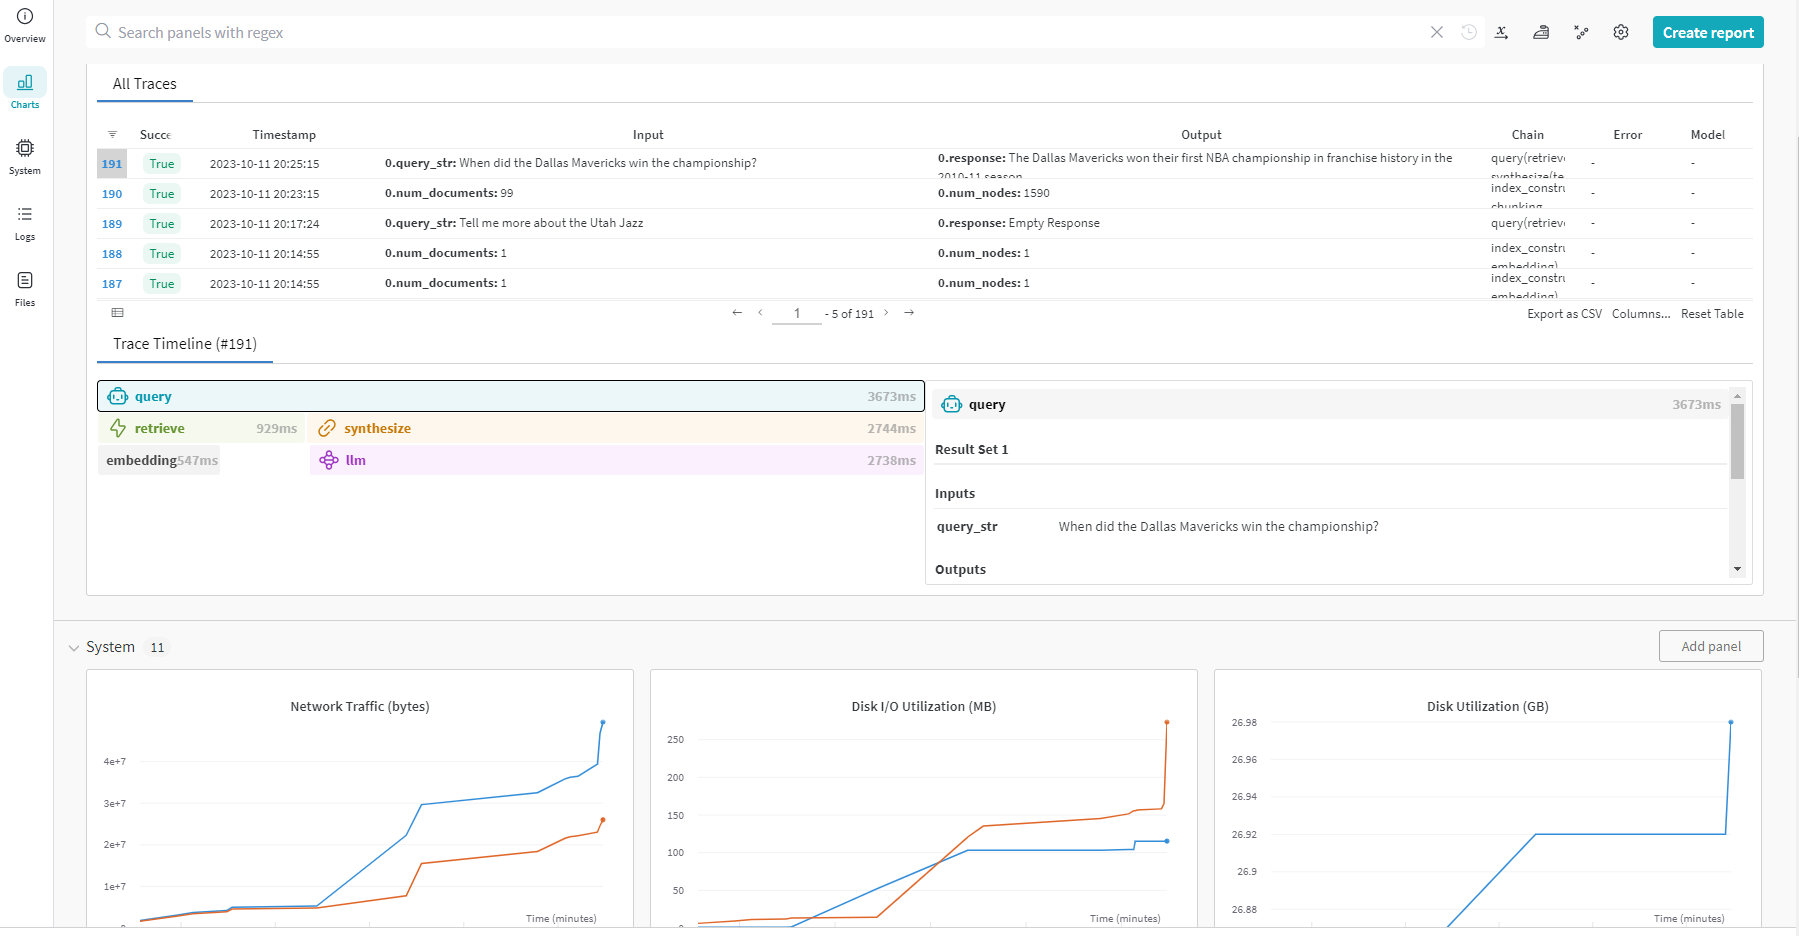

## (optional) Cleanup

You may want to clean up your database: in that case, simply run the following cell.

_Warning: this will delete the vector store and all that you stored into it!_

In [ ]:
session.execute(f"DROP TABLE IF EXISTS {keyspace}.{table_name};")